In [ ]:
#@title Imports
from typing import Optional

import abc
import numpy as np
from scipy.stats import beta
import random
import pandas as pd
import plotnine as gg
import matplotlib.pyplot as plt
import pylab
import scipy.signal as signal

colors = {0: 'b',
          1: 'g',
          2: 'r',
          3: 'c',
          4: 'm',
          5: 'y',
          6: 'k'}

# Value-IDS

In [ ]:
#@title Graph Environment

class Graph(object):
	def __init__(self,
				 transitions_deterministic=True,
				 max_length = 2,
                 rewarding_state = None):
		self.allowable_actions = [0,1]
		self.n_actions = len(self.allowable_actions)
		self.n_dim = 2*max_length - 1
		split = np.array_split(np.arange(2, 2*max_length)-1, -1)
		self.max_length = max_length
        self.rewarding_state = rewarding_state # TODO: need to generate at random; store in the informative state
		self.info = None
        
        mask = np.eye(2*max_length - 1)
        mask[rewarding_state] = np.ones(2*max_length - 1)
        self.mask = mask
        
        self.reset()

	def num_states(self):
		return self.n_dim

	def pos_to_image(self, x):
		'''latent state -> representation '''
		return x

	def reset(self):
		self.state = 0
		self.done = False
		return np.array([self.state])

	def step(self, action):
		assert action in self.allowable_actions
		assert not self.done, 'Episode Over'
		reward = 0 if not self.stochastic_rewards else np.random.randn()
		prev_state = self.state
        
        if self.state == (self.rewarding_state) and (action == 1):
            reward = 1
        else:
            reward = 0

		if self.state == (2*self.max_length-3):
            self.state = 0
            self.done = True
        elif self.state == (2*self.max_length-2):
			self.state = 0
            self.info = self.rewarding_state
			self.done = True
		else:
			if self.state % 2 == 1:
                self.state = self.state + 2
            else:
                if action == 0:
                    self.state = self.state + 2
                else:
                    self.state = self.state + 1

		state = self.state

		return np.array([self.state]), reward, self.info, self.done, {}

	def render(self, a=None, r=None, return_arr=False):
		start_state = 1 if self.state == 0 else 0
		state = np.zeros(2*self.max_length-2)
		end_state = 1 if self.state == (2*self.max_length-1) else 0

		if not start_state and not end_state:
			state[self.state-1] = 1

		if return_arr:
			return start_state, state.reshape(2,self.max_length-1, order='F'), end_state
		else:

			print(' ', ' '.join(state.reshape(2,self.max_length-1, order='F')[0].astype(int).astype(str).tolist()), '  ')
			if (a is not None) and (r is not None):
				print(start_state, ' '*((2*(self.max_length-2))+1), end_state, ' (a,r): ', (a,r), '.  If POMDP, End state: ', end_state)
			else:
				print(start_state, ' '*((2*(self.max_length-2))+1), end_state)
			print(' ', ' '.join(state.reshape(2,self.max_length-1, order='F')[1].astype(int).astype(str).tolist()), '  ')
			print('\n')
			# print([start_state], [end_state], state.reshape(2,self.max_length-1, order='F'), )

In [ ]:
def value_iter(t, p, r):
  num_action = p.shape[2]
  num_state = p.shape[1]
  num_samples = p.shape[0]
  H = (num_state + 1) / 2 # TODO: check
  V = np.zeros((num_samples, num_state,))
  for _ in range (H - 1, t-1, -1):
    Q = r + np.sum(p * V, axis=-1)
    V = np.amax(Q, axis=-1)
#     Q = (p*(r + V[:,None]).transpose()[None]).sum(axis=-1) #shape: (state, actionn)
#     V = Q.max(axis=-1) #(state,)
  return Q, V

## Information ratio

We use Equation (17) in Reinforcement Learning, Bit by Bit to compute the information ratio:
\begin{equation}
\min_{\nu\in\Delta_{\mathcal{A}}}\frac{\mathbb{E}\left[\max_{a\in\mathcal{A}}\hat{Q}_{*,t}(S_t,a) - \hat{Q}_{*,t}(S_t,\tilde{A}_t)\right]^2}{\mathbb{E}\left[\text{tr}\left(\text{Cov}\left[\hat{Q}_{\dagger,t}(S_t,\tilde{A}_t)\mid X_t,\tilde{A}_t,\hat{\pi}_t(\cdot\mid S_t)\right]\mid X_t,\tilde{A}_t\right)\mid X_t\right]}
\end{equation}
Using convexity analysis in Russo & Van Roy (2014a, 2018), one can show that there exists a policy that randomizes between at most two actions. Therefore, we only need to iterate over pairs of actions $a_1,a_2$, and find the $\alpha\in[0,1]$ such that $\nu$, where $\nu(a_1)=\alpha, \nu(a_2)=1-\alpha$, minimizes the above expression. For simplicity of notation, we define
\begin{align*}
A_1 &= \max_{a\in\mathcal{A}}\hat{Q}_{*,t}(S_t,a) - \hat{Q}_{*,t}(S_t,a_1)\\
A_2 &= \max_{a\in\mathcal{A}}\hat{Q}_{*,t}(S_t,a) - \hat{Q}_{*,t}(S_t,a_2)\\
C_1 &= \text{tr}\left(\text{Cov}\left[\hat{Q}_{\dagger,t}(S_t,a_1)\right]\right)\\
C_2 &= \text{tr}\left(\text{Cov}\left[\hat{Q}_{\dagger,t}(S_t,a_2)\right]\right)
\end{align*}
Therefore, we want to find the optimal $\alpha\in[0,1]$ that minimizes
\begin{equation}
f(\alpha) = \frac{\mathbb{E}[\alpha A_1 + (1-\alpha)A_2]^2}{\alpha C_1 + (1-\alpha) C_2}.
\end{equation}
Using algebra, we get that 
\begin{equation}
f'(\alpha_0) = 0\quad\text{when}~\alpha_0=\frac{A_2C_1 - 2A_1C_2 + A_2C_2}{(C_1-C_2)(A_1-A_2)}
\end{equation}
In particular, we only need to compare the following values
\begin{align*}
f(0) &= \frac{A_2^2}{C_2}\\
f(1) &= \frac{A_1^2}{C_1}\\
f(\alpha_0) &= \frac{4(A_1-A_2)(A_2C_1-A_1C_2)}{(C_1-C_2)^2}
\end{align*}

In [ ]:
def var_ids_action(rng, t, state, num_trans: np.ndarray, num_success: np.ndarray, num_failure: np.ndarray,
                   num_good_obs: np.ndarray, num_bad_obs: np.ndarray, obs_masks: np.ndarray, num_sample: int = 32):
  num_action = num_trans.shape[1]
  num_state = num_trans.shape[0]
#   num_action = len(num_success)

#   p_samples = rng.beta(np.tile(num_success + 1, (num_sample, 1)), np.tile(num_failure + 1, (num_sample, 1)))
  trans_shape = num_trans.shape
  reward_shape = num_success.shape
  p_samples = rng.dirichlet(np.tile(num_trans.reshape(-1), (num_sample, 1)))
  r_samples = rng.beta(np.tile((num_success + 1).reshape(-1), (num_sample, 1)), np.tile((num_failure + 1).reshape(-1), (num_sample, 1)))
  c_samples = rng.beta(np.tile((num_good_obs + 1).reshape(-1), (num_sample, 1)), np.tile((num_bad_obs + 1).reshape(-1), (num_sample, 1)))
  
  Q_hat, V_hat = value_iter(t, p_samples.reshape(num_sample, *trans_shape), r_samples.reshape(num_samples, *reward_shape))
  Q_cross, _ = value_iter(t, p_samples.reshape(num_sample, *trans_shape), c_samples.reshape(num_samples, *reward_shape))

  # Minimize information ratio over 2-sparse policies
  info_ratio = np.zeros([num_action, num_action])
  
  A1 = (V_hat[:,state, None] - Q_hat[:,state,:]).mean(0)
  A2 = A1
  C1 = np.array([np.trace(np.cov(Q_cross[:,state,a])) for a in range(num_action)])
  C2 = C1

  f_alpha = 4*(A1[None,:] - A2[:,None])*(A2[:,None]*C1[None,:] - A1[None,:]*C2[:,None]) / (C1[None,:] - C2[:,None])**2
  f_0 = np.tile(A2[:,None]**2 / C2[:,None], (1, num_action))
  f_1 = np.tile(A1[None,:]**2 / C1[None,:], (num_action, 1))
  alphas = (A2[:,None]*C1[None,:] - 2*A1[None,:]*C2[:,None] + np.tile(A2[:,None]*C2[:,None], (1, num_action))) / (C1[None,:] - C2[:,None])*(A1[None,:] - A2[:,None])
  f_matrix = np.stack([f_0, f_alpha, f_1], axis=0)
  index = np.argmax(f_matrix)
  index = np.unravel_index(index, f_matrix.shape)
  assert f_matrix[index[0],index[1],index[2]] == f_matrix.max()
    
  alpha = alphas[index[1], index[2]] if index[0] == 1 else index[0]
  action = np.zeros(num_action)
  action[index[1]] = alpha
  action[index[2]] = 1 - alpha
  
  return rng.choice(np.arange(num_action), p=action)

var_ids_agent = LearnFromObsAgent(compute_action=var_ids_action)

In [ ]:
class VarIDSAgent(Agent):
  def __init__(self, compute_action):
    self._compute_action = compute_action
    self._state = 0
    self._rng = None
    
  def reset(self, rng: np.random.Generator, obs_masks: np.ndarray):
    self._obs_masks = obs_masks
    self._num_action = 2
    self._num_state = obs_masks.shape[0]
    self._rng = rng
    self._state = 0
    
    self._num_trans = np.ones(shape=(self._num_state, self._num_action, self._num_state,)) / self._num_state
    self._num_success = np.zeros(shape=(self._num_state, self._num_action,))
    self._num_failure = np.zeros(shape=(self._num_state, self._num_action,))
    self._num_good_obs = np.zeros(shape=(self._num_state, self._num_action,))
    self._num_bad_obs = np.zeros(shape=(self._num_state, self._num_action,))
  
  def update(self, action: int, next_state, obs: np.ndarray):
    
    self._num_trans[self.state, action, next_state] += 1
    self._num_success[self.state, action] += obs[self.state, action]
    self._num_failure[self.state, action] += 1 - obs[self.state, action]
    self._num_good_obs += np.nan_to_num(obs)
    self._num_bad_obs += np.nan_to_num(1 - obs)

  def select_action(self, t: int):
    return self._compute_action(self._rng, t, self._state, self._num_trans, self._num_success, self._num_failure,
                                self.num_good_obs, self.num_bad_obs, self._obs_masks)

In [ ]:
#@title Utilities for running the experiments
def run_graph_rl_experiment(
    num_sims: int, 
    num_episodes: int, 
    agent,
    plot_results=False):
    
  T = 7
  env = Graph(max_length=T, rewarding_state=3)
  
  num_state = 2*T - 1
  horizon = T - 1
  num_action = 2
  sims = range(num_sims)
  episodes = range(num_episodes)
  num_timesteps = num_episodes*horizon
  actions = list(range(num_action))

  action_count = []
  
  for sim in sims:
    rng = np.random.default_rng(sim)
    
    agent.reset(rng, obs_masks)
    action_count += [[num_timesteps*[0] for a in actions]]
    for episode in episodes:
      a = agent.select_action() 
      # Generate observation for all arms.
      obs = 
      # Mask the arms that are not observed.
      mask = 
      obs[np.logical_not(mask)] = np.nan
      agent.update(a, obs)

      action_count[sim][a][timestep] = 1

  action_count1 = [[float(action_count[0][a][t]) 
    for t in range(num_timesteps)] for a in actions]
  action_count = [[sum([float(action_count[sim][a][t]) 
    for sim in sims]) / num_sims 
    for t in range(num_timesteps)] for a in actions]

  # plot action frequencies averaged over simulations
  for a in actions:
    plt.plot(timesteps,
             pd.Series(action_count[a]).rolling(10, min_periods=1).mean(),
             colors[a], label='$a =$' + str(a+1))
  plt.axis([0,num_timesteps+1,0.0,1.01])
  plt.xlabel(r'time $t$', fontsize=20)
  plt.ylabel('$\mathbb{P}(A_t = a|\mathcal{E})$', fontsize=20)
#  plt.ylabel('$\mathrm{E}[N_{t,a} - N_{t-1,a}|\mathcal{E}]$', fontsize=20)
  pylab.legend(loc='best')
  plt.show()

  # plot action counts over single simulation
  for a in actions:
    plt.plot(timesteps, np.cumsum(action_count1[a]), colors[a], label='$a =$' + str(a+1))
  plt.axis([0,num_timesteps+1,0.0,num_timesteps+1])
  plt.xlabel(r'time $t$', fontsize=20)
  plt.ylabel('$N_{t,a}$', fontsize=20)
  pylab.legend(loc='best')
  plt.show()

  # plot action counts averaged over simulations
  for a in actions:
    plt.plot(timesteps, np.cumsum(action_count[a]), colors[a], label='$a =$' + str(a+1))
  plt.axis([0,num_timesteps+1,0.0,num_timesteps+1])
  plt.xlabel(r'time $t$', fontsize=20)
  plt.ylabel('$\mathrm{E}[N_{t,a}|\mathcal{E}]$', fontsize=20)
  pylab.legend(loc='best')
  plt.show()

  return action_count


In [ ]:
#@title TS agent that learns from reward.
num_sims = 1000 # number of simulations over which to average
num_timesteps = 1000 # number of time steps to simulate

action_count_ts_reward = run_bernoulli_bandit_experiment(
    num_sims, 
    num_timesteps, 
    agent=ts_learn_from_reward,
    plot_results=True)

# Interfaces, utilities and experiment constants

In [ ]:
#@title Agent interface
class Agent(metaclass=abc.ABCMeta):

  @abc.abstractmethod
  def reset(self, rng: np.random.Generator, obs_masks: np.ndarray) -> None:
    # Reset the agent.
    raise NotImplementedError

 
  @abc.abstractmethod
  def update(self, action: int, obs: np.ndarray) -> None:
    # Update agent state.
    raise NotImplementedError

  @abc.abstractmethod
  def select_action(self) -> int:
    # Select an action.
    raise NotImplementedError

In [ ]:
#@title Experiment constants
MEANS = [0.55, 0.5, 0.6, 0.45, 0.55, 0.4]
OBS_MASKS = np.array([[1, 1, 1, 0, 1, 0],
                      [0, 1, 0, 1, 0, 0], 
                      [1, 0, 1, 0, 0, 0],
                      [0, 0, 1, 1, 0, 1],
                      [0, 0, 0, 0, 1, 0],
                      [0, 1, 0, 0, 0, 1],
                      ])

In [ ]:
#@title Utilities for running the experiments

def random_argmax(rng, scores: np.ndarray):
  probs = (scores==scores.max()).astype(np.float32)
  probs /= probs.sum()
  return rng.choice(np.arange(scores.size), p=probs)


def run_bernoulli_bandit_experiment(
    num_sims: int, 
    num_timesteps: int, 
    agent,
    means: np.ndarray = MEANS,
    obs_masks: np.ndarray = OBS_MASKS,
    plot_results=False):
                              
  obs_masks = obs_masks.astype(bool)
  num_action = len(means)
  sims = range(num_sims)
  timesteps = range(num_timesteps)
  actions = list(range(num_action))

  action_count = []
  p = means[:]

  for sim in sims:
    rng = np.random.default_rng(sim)
    agent.reset(rng, obs_masks)
    action_count += [[num_timesteps*[0] for a in actions]]
    for timestep in timesteps:
      a = agent.select_action() 
      # Generate observation for all arms.
      obs = rng.binomial(1,p).astype(float)
      # Mask the arms that are not observed.
      mask = obs_masks[a, :]
      obs[np.logical_not(mask)] = np.nan
      agent.update(a, obs)

      action_count[sim][a][timestep] = 1

  action_count1 = [[float(action_count[0][a][t]) 
    for t in range(num_timesteps)] for a in actions]
  action_count = [[sum([float(action_count[sim][a][t]) 
    for sim in sims]) / num_sims 
    for t in range(num_timesteps)] for a in actions]

  # plot action frequencies averaged over simulations
  for a in actions:
    plt.plot(timesteps,
             pd.Series(action_count[a]).rolling(10, min_periods=1).mean(),
             colors[a], label='$a =$' + str(a+1))
  plt.axis([0,num_timesteps+1,0.0,1.01])
  plt.xlabel(r'time $t$', fontsize=20)
  plt.ylabel('$\mathbb{P}(A_t = a|\mathcal{E})$', fontsize=20)
#  plt.ylabel('$\mathrm{E}[N_{t,a} - N_{t-1,a}|\mathcal{E}]$', fontsize=20)
  pylab.legend(loc='best')
  plt.show()

  # plot action counts over single simulation
  for a in actions:
    plt.plot(timesteps, np.cumsum(action_count1[a]), colors[a], label='$a =$' + str(a+1))
  plt.axis([0,num_timesteps+1,0.0,num_timesteps+1])
  plt.xlabel(r'time $t$', fontsize=20)
  plt.ylabel('$N_{t,a}$', fontsize=20)
  pylab.legend(loc='best')
  plt.show()

  # plot action counts averaged over simulations
  for a in actions:
    plt.plot(timesteps, np.cumsum(action_count[a]), colors[a], label='$a =$' + str(a+1))
  plt.axis([0,num_timesteps+1,0.0,num_timesteps+1])
  plt.xlabel(r'time $t$', fontsize=20)
  plt.ylabel('$\mathrm{E}[N_{t,a}|\mathcal{E}]$', fontsize=20)
  pylab.legend(loc='best')
  plt.show()

  return action_count


# Learning from reward vs learning from obervation

In [ ]:
#@title An agent that learns from reward
class LearnFromRewardAgent(Agent):
  def __init__(self, compute_action):
    self._compute_action = compute_action
    self._rng = None

  def reset(self, rng: np.random.Generator, obs_masks: np.ndarray):
    self._obs_masks = obs_masks
    self._num_action = obs_masks.shape[0]
    self._rng = rng
    self._num_success = np.zeros(shape=(self._num_action,))
    self._num_failure = np.zeros(shape=(self._num_action,))
  
  def update(self, action: int, obs: np.ndarray):
    self._num_success[action] += obs[action]
    self._num_failure[action] += 1 - obs[action]

  def select_action(self):
    return self._compute_action(self._rng, self._num_success, self._num_failure, 
                                self._obs_masks)


In [ ]:
class LearnFromObsAgent(Agent):
  def __init__(self, compute_action):
    self._compute_action = compute_action
    self._rng = None

  def reset(self, rng: np.random.Generator, obs_masks: np.ndarray):
    self._obs_masks = obs_masks
    self._num_action = obs_masks.shape[0]
    self._rng = rng
    self._num_success = np.zeros(shape=(self._num_action,))
    self._num_failure = np.zeros(shape=(self._num_action,))
  
  def update(self, action: int, obs: np.ndarray):
    self._num_success += np.nan_to_num(obs)
    self._num_failure += np.nan_to_num(1 - obs)

  def select_action(self):
    return self._compute_action(self._rng, self._num_success, self._num_failure, 
                                self._obs_masks)


In [ ]:
def ts_action(rng, num_successe: np.ndarray, num_failure: np.ndarray,
              obs_masks: Optional[np.ndarray] = None):
  del obs_masks
  p_hat = rng.beta(num_successe+1, num_failure+1)
  return random_argmax(rng, p_hat)

ts_learn_from_reward = LearnFromRewardAgent(compute_action=ts_action)
ts_learn_from_obs = LearnFromObsAgent(compute_action=ts_action)

## Question 1
You just need to run the following cell to experiment with the TS agent that learns from reward.

In [ ]:
#@title TS agent that learns from reward.
num_sims = 1000 # number of simulations over which to average
num_timesteps = 1000 # number of time steps to simulate

action_count_ts_reward = run_bernoulli_bandit_experiment(
    num_sims, 
    num_timesteps, 
    agent=ts_learn_from_reward,
    plot_results=True)

## Question 2
Implement the `update` method for `LearnFromObsAgent` and then run the following cess to run an experiment with TS agent that learns from observation. You may want to set `num_sims=1` while you are testing your code to iterate faster. Set it back to `num_sims=1000` for your final run before submitting your solution.

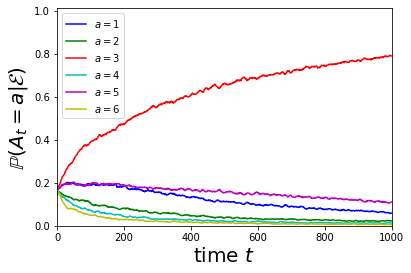

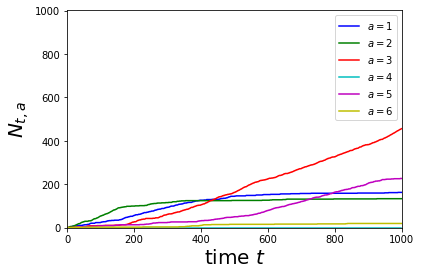

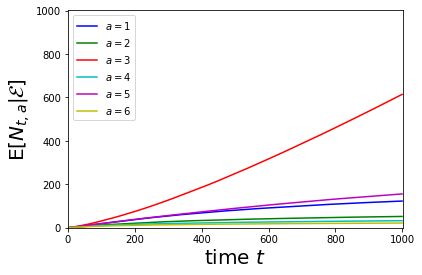

In [ ]:
#@title TS agent that learns from observation.

num_sims = 1000 # number of simulations over which to average
num_timesteps = 1000 # number of time steps to simulate

action_count_ts_obs = run_bernoulli_bandit_experiment(
    num_sims, 
    num_timesteps, 
    agent=ts_learn_from_obs,
    plot_results=True)

# Information directed sampling

For the IDS action selection we need to compute the mutual information 
\begin{align}
\textrm{I}(\theta; O_{t+1} | H_t=H_t, A_t=a) &= \sum_{n = 1}^{N} \textrm{I}(\theta_n; O_{t+1, n} | H_t=H_t, A_t=a) \\
& = \sum_{n = 1}^{N} \textrm{h}(\theta_n|H_t=H_t, A_t=a) - \textrm{h}(\theta_n|H_t=H_t, A_t=a, O_{t+1, n})\\
& = \sum_{n = 1}^{N} \left\{ \textrm{h}(\theta_n|H_t=H_t) - \sum_{o = \{1, 2\}} \Pr(O_{t+1, n}=o) \, \textrm{h}(\theta_n|H_t=H_t, A_t=a, O_{t+1, n}=o) \right\}\\
\end{align}

## Question 3

The function `beta_bern_mutual_info` implements this mutual information $\mathrm{I}(p; O)$ between two random variables $p \sim \mathrm{Beta}(a, b)$ and $O \sim \mathrm{Bernoulli}(p)$. Use this function to implement the IDS action selection. (Note that in `beta_bern_mutual_info` the Beta parameter `a = num_success + 1`)


In [ ]:
def beta_bern_mutual_info(num_success: np.ndarray, num_failure: np.ndarray):
  a = num_success + 1
  b = num_failure + 1
  conditional_entropy = beta.mean(a, b) * beta.entropy(a + 1, b) + (1 - beta.mean(a, b)) * beta.entropy(a, b + 1)
  return beta.entropy(a, b) - conditional_entropy

def ids_action(rng, num_success: np.ndarray, num_failure: np.ndarray,
               obs_masks: np.ndarray):
  mutual_infos = beta_bern_mutual_info(num_success, num_failure)
  partial_obs_mutal_info = np.sum(mutual_infos[np.newaxis, :] * obs_masks, axis=1)
  p_samples = rng.beta(np.tile(num_success + 1, (10, 1)), np.tile(num_failure + 1, (10, 1)))
  shortfalls = (np.max(p_samples, axis=1, keepdims=True) - p_samples).mean(axis=0)
  info_ratio = shortfalls**2 / (partial_obs_mutal_info + 1e-9)
  return random_argmax(rng, -info_ratio)

ids_agent = LearnFromObsAgent(compute_action=ids_action)

In [ ]:
#@title Run the experiment for the IDS agent 

num_sims = 20 # number of simulations over which to average
num_timesteps = 1000 # number of time steps to simulate

action_count_ids = run_bernoulli_bandit_experiment(
    num_sims, 
    num_timesteps, 
    agent=ids_agent,
    plot_results=True)

## Question 4
If we change the learning target to be the optimal action instead of the environment parameter the mutual information is not easy to compute. Implement the sample based variance IDS agent discussed in Lecture 9. Note that the observation is a vector in this case. Compute the variances of conditional expectation for each observation dimension and take the sum of all these variances as the information gain surrogate. (You can vectorize this operation, you don't need to do it in a for loop for each dimension separatly. However, for loop is fine but it is going to be slow).

In [ ]:
def var_ids_action(rng, num_success: np.ndarray, num_failure: np.ndarray,
                   obs_masks: np.ndarray, num_sample: int = 32):
  num_action = len(num_success)
  p_samples = rng.beta(np.tile(num_success + 1, (num_sample, 1)), np.tile(num_failure + 1, (num_sample, 1)))
  shortfalls = (np.max(p_samples, axis=1, keepdims=True) - p_samples).mean(axis=0)

  # Compute variance of conditional means using samples.
  df = pd.DataFrame(p_samples, columns=range(num_action))
  df_mean = df.mean()
  df['opt_action'] = df.apply(lambda x: random_argmax(rng, x), axis=1)
  df_cond_mean = df.groupby('opt_action').mean()
  opt_action_prob = df.opt_action.value_counts(normalize=True, sort=False)
  var_cond_mean = (
      df_cond_mean.apply(lambda x: x - df_mean, axis=1) ** 2
  ).apply(
      lambda x: np.sum(x * opt_action_prob), axis=0
      ).sort_index().to_numpy()
  # to gaurd against the case where all samples have the same opt action. 
  var_cond_mean = np.nan_to_num(var_cond_mean) 
  var_trace = np.sum(var_cond_mean[np.newaxis, :] * obs_masks, axis=1)
  info_ratio = shortfalls**2 / (var_trace + 1e-9)
  return random_argmax(rng, -info_ratio)

var_ids_agent = LearnFromObsAgent(compute_action=var_ids_action)

In [ ]:
#@title Run the experiment for the variance IDS agent. 

num_sims = 20 # number of simulations over which to average
num_timesteps = 1000 # number of time steps to simulate

action_count_var_ids = run_bernoulli_bandit_experiment(
    num_sims, 
    num_timesteps, 
    agent=var_ids_agent,
    plot_results=True)

In [ ]:
def cregret_from_acount(action_count: np.ndarray):
  """Compute expected cumulative regret from action count."""
  exp_rew = (action_count * np.array(MEANS)[:, np.newaxis]).sum(axis=0)
  exp_cumulative_rew = np.cumsum(exp_rew)
  exp_opt_cumulative_rew = max(MEANS) * np.arange(len(exp_cumulative_rew))
  return exp_opt_cumulative_rew - exp_cumulative_rew

regret_df = pd.DataFrame({
    'ts_obs': cregret_from_acount(np.array(action_count_ts_obs)),
    'ts_reward': cregret_from_acount(np.array(action_count_ts_reward)),
    'ids': cregret_from_acount(np.array(action_count_ids)),
    'var_ids': cregret_from_acount(np.array(action_count_var_ids)),
})

regret_df = regret_df.reset_index().rename({'index': 'timestep'}, axis=1)
regret_df = regret_df.melt(var_name='agent', value_name='cumulative_regert', 
                           id_vars=['timestep'])
p = (
    gg.ggplot(regret_df) 
    + gg.aes(x='timestep', y='cumulative_regert', color='agent')
    + gg.geom_line()
)
p